In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.special import binom

from utils import *

In [2]:
handler = Signal_Handler()
display = Signal_Display()

# Задание 1

In [3]:
def running_mean(signal: np.ndarray, k: int):
       
    signal = np.pad(signal, (k, k), mode = 'edge')

    return np.array([1 / (2 * k + 1) * np.sum(signal[i - k : i + k]) 
                     for i in range(k, signal.size - k)]) 

In [4]:
x1, y1, dt = handler.make_signal('rect', interval = (-4, 4), A = 2, w = Converter(T = 2).w)
y1 += np.random.normal(0, 1, y1.size)

In [5]:
k = 15
y_filtred = running_mean(y1, k = k)

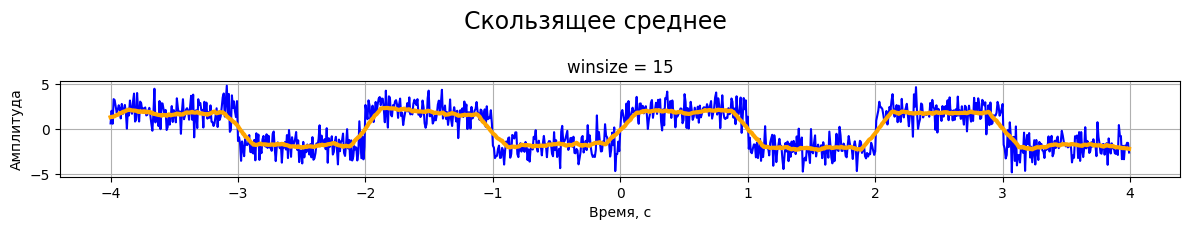

In [6]:
display.clear()

display.make_plot(0, x1, y1, title = f'winsize = {k}')
display.make_plot(0, x1, y_filtred, color = 'orange', linewidth = 3)

display.plot(title = f'Скользящее среднее')

# Задание 2

In [7]:
def Gaussian_smoothing(time: np.ndarray, signal: np.ndarray, k: int, fwhm: float):
    
    signal = np.pad(signal, (k, k), mode = 'edge')
    g = np.pad(np.exp((-4 * np.log(2) * time ** 2) / fwhm ** 2), 
               (k, k), mode = 'edge')
    
    return np.array([1 / (2 * k + 1) * np.sum(signal[i - k : i + k] * g[i - k : i + k]) 
                     for i in range(k, signal.size - k)])

In [8]:
x1, y1, dt = handler.make_signal('rect', interval = (-4, 4), A = 2, w = Converter(T = 2).w)
y1 += np.random.normal(0, 1, y1.size)

In [9]:
k = 10
fwhm = 15
y_filtred = Gaussian_smoothing(x1, y1, k = k, fwhm = fwhm)

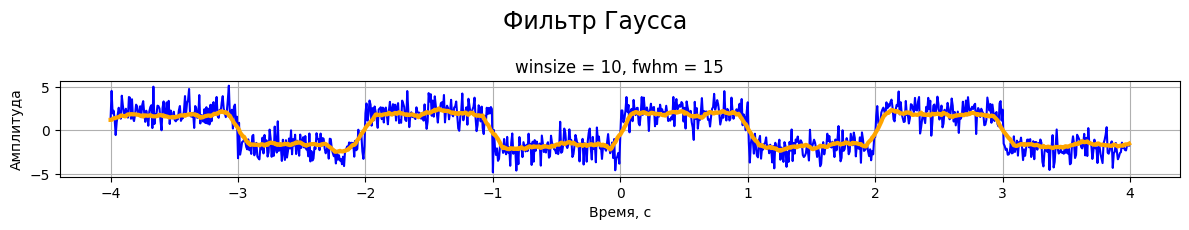

In [10]:
display.clear()

display.make_plot(0, x1, y1, title = f'winsize = {k}, fwhm = {fwhm}')
display.make_plot(0, x1, y_filtred, color = 'orange', linewidth = 3)

display.plot(title = f'Фильтр Гаусса')

# Задание 3

In [11]:
x1 = np.linspace(0, 4, num = 250, endpoint = False)
y1 = np.random.randint(2, size = x1.size)

In [12]:
k = 5
fwhm = 20
y_filtred = Gaussian_smoothing(x1, y1, k = k, fwhm = fwhm)

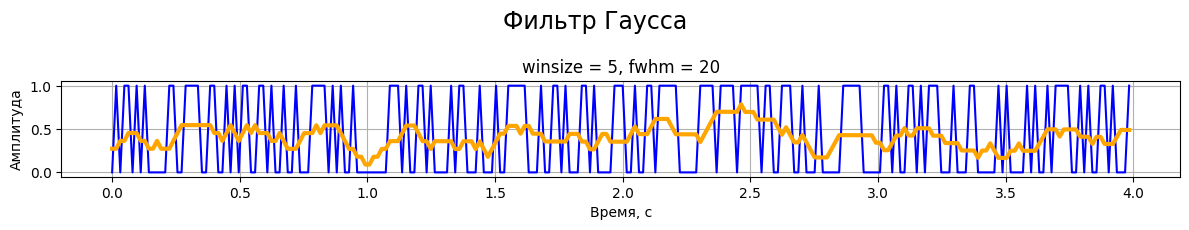

In [13]:
display.clear()

display.make_plot(0, x1, y1, title = f'winsize = {k}, fwhm = {fwhm}')
display.make_plot(0, x1, y_filtred, color = 'orange', linewidth = 3)

display.plot(title = f'Фильтр Гаусса')

# Задание 4

In [14]:
def median_filter(signal: np.ndarray, k: int):
    
    signal = np.pad(signal, (k // 2, k // 2), mode = 'edge')
    
    return np.array([np.median(signal[i: i + k]) for i in range(signal.size - k + 1)])               

In [15]:
x1 = np.linspace(0, 4, num = 250, endpoint = False)
y1 = np.random.randint(10, size = x1.size)

In [16]:
k = 20
y_filtred = median_filter(y1, k = k)

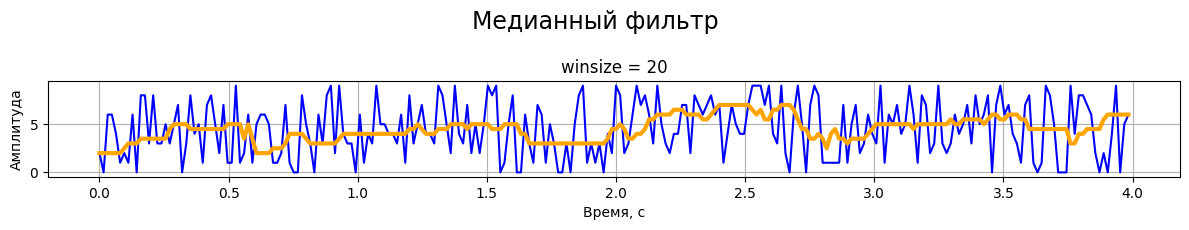

In [17]:
display.clear()

display.make_plot(0, x1, y1, title = f'winsize = {k}')
display.make_plot(0, x1, y_filtred, color = 'orange', linewidth = 3)

display.plot(title = f'Медианный фильтр')

# Задание 5

In [18]:
def spectral_interpolation(time: np.ndarray, signal: np.ndarray, break_time: tuple, win_size: int):

    handler = Signal_Handler()

    signal1 = signal[time < break_time[0]]
    signal2 = signal[time > break_time[1]]

    yfft1 = handler.find_spectrum(signal1[-win_size:], 1)[1]
    yfft2 = handler.find_spectrum(signal2[:win_size], 1)[1]
    
    yfft = np.mean([yfft1, yfft2], axis = 0, dtype = np.complex128)
    signal_restored = handler.from_spectrum(yfft)

    missing_points = time[(time >= break_time[0]) & (time <= break_time[1])]
    points_num = missing_points.size - signal_restored.size

    link1 = np.interp(missing_points[:points_num // 2], xp = time[time < break_time[0]], fp = signal1)  
    link2 = np.interp(missing_points[-points_num // 2:], xp = time[time > break_time[1]], fp = signal2)

    return np.concatenate([signal1, link1, signal_restored, link2, signal2])

In [19]:
x1, y1, dt = handler.make_signal('cos', interval = (0, 10), A = 1, w = Converter(f = 2).w)

In [20]:
y_ds = y1.copy()
y_ds[(x1 >= 5) & (x1 <= 7)] = 0

In [21]:
signal_restored = spectral_interpolation(x1, y_ds, (5, 7), 200)

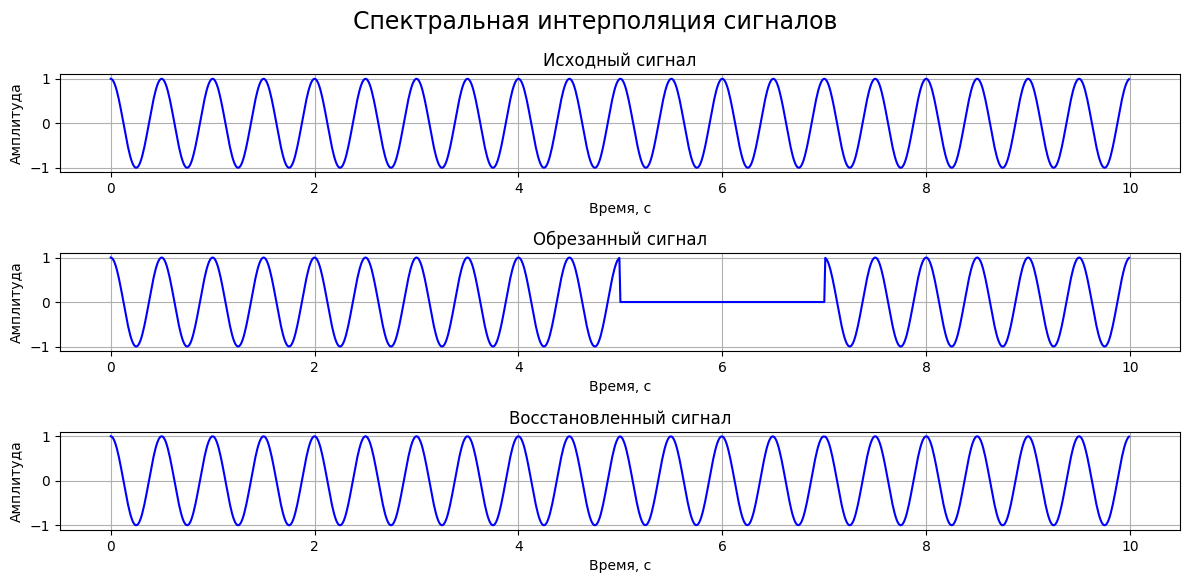

In [22]:
display.clear()

display.make_plot(0, x1, y1, title = 'Исходный сигнал')
display.make_plot(1, x1, y_ds, title = 'Обрезанный сигнал')
display.make_plot(2, x1, signal_restored, title = 'Восстановленный сигнал')

display.plot(title = f'Спектральная интерполяция сигналов')

# Задание 6

In [23]:
class Chebyshev_filter:

    def __init__(self, signal: np.ndarray, dt: float):
        handler = Signal_Handler()
        self.xfft, self.yfft = handler.find_spectrum(signal, dt)

    def update_signal(self, signal : np.ndarray, dt: float):
        self.xfft, self.yfft = handler.find_spectrum(signal, dt)

    def H_w(self, w: float, wc: float, eps: float = 0.1, order: int = 2):
        
        x = w / wc

        C = np.array([binom(order, 2 * k) for k in range(order // 2)]).T
        arg1 = np.array([(x ** 2 - 1) ** k for k in range(order // 2)])
        arg2 = np.array([x ** (order - 2 * k) for k in range(order // 2)])

        T = np.sum(C * arg1 * arg2, axis = 0)

        return 1 / np.sqrt(1 + eps ** 2 * T ** 2) 

    def LPF(self, wc: np.ndarray, eps: float = 0.1, order: int = 2):
        return handler.from_spectrum(np.abs(self.H_w(self.xfft, wc, eps, order) * self.yfft))

In [24]:
def downsample(time: np.ndarray, signal: np.ndarray, N: int):
    
    filter = Chebyshev_filter(signal, (time[-1] - time[0]))
    new_fs = time.size / (N * (time[-1] - time[0]))

    return time[::N], filter.LPF(new_fs / 2)[::N]

In [25]:
def upsample(time: np.ndarray, signal: np.ndarray, N: int):
    
    new_time = np.linspace(time[0], time[-1], num = time.size * N)
    new_signal = np.interp(new_time, xp = time, fp = signal)

    return new_time, new_signal

In [26]:
x1, y1, dt1 = handler.make_signal('cos', interval = (0, 0.1), A = 1, w = Converter(f = [50, 100]).w)
x2, y2, dt2 = handler.make_signal('cos', interval = (0, 0.1), sample_rate = 200, A = 1, w = Converter(f = [50, 100]).w)

In [27]:
N = 50
x_ds, y_ds = downsample(x1, y1, N)
x_us, y_us = upsample(x2, y2, N)

In [28]:
dt_ds = x_ds.size / (x_ds[-1] - x_ds[0])
dt_us = x_us.size / (x_us[-1] - x_us[0])

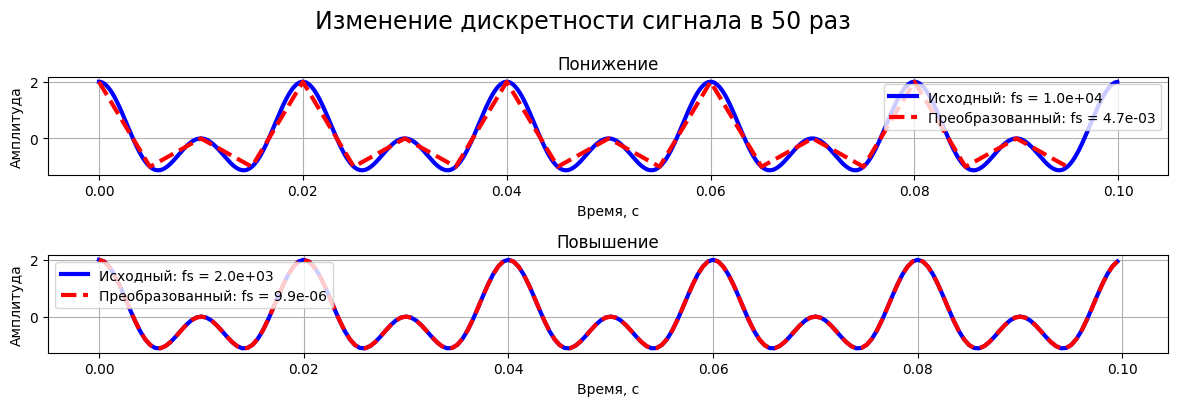

In [29]:
display.clear()

display.make_plot(0, x1, y1, legend = f'Исходный: fs = {1 / dt1:.1e}', linewidth = 3, title = 'Понижение')
display.make_plot(0, x_ds, y_ds, legend = f'Преобразованный: fs = {1 / dt_ds:.1e}', color = 'red', linestyle = '--', linewidth = 3)

display.make_plot(1, x2, y2, legend = f'Исходный: fs = {1 / dt2:.1e}', linewidth = 3, title = 'Повышение')
display.make_plot(1, x_us, y_us, legend = f'Преобразованный: fs = {1 / dt_us:.1e}', color = 'red', linestyle = '--', linewidth = 3)

display.plot(title = f'Изменение дискретности сигнала в {N} раз')

# Задание 7

In [30]:
x_ds, y_ds, dt1 = handler.make_signal('cos', interval = (0, 0.1), sample_rate = 1000, A = 1, w = Converter(f = 50).w)
x2, y2, dt2 = handler.make_signal('cos', interval = (0, 0.1), sample_rate = 50, A = 1, w = Converter(f = 50).w)
x3, y3, dt3 = handler.make_signal('cos', interval = (0, 0.1), sample_rate = 10, A = 1, w = Converter(f = 50).w)

In [31]:
x1_res, y1_res = downsample(x_ds, y_ds, 10)
x2_res, y2_res = upsample(x2, y2, 10)
x3_res, y3_res = upsample(x3, y3, 50)

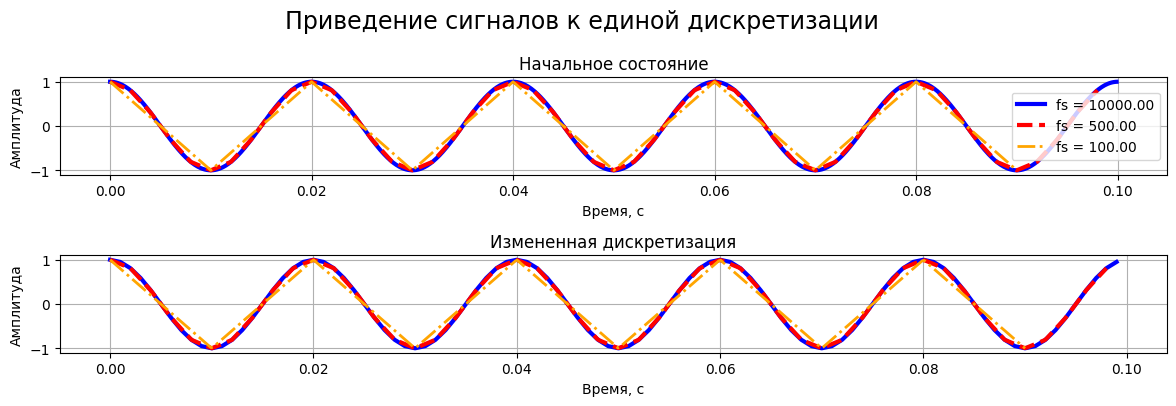

In [32]:
display.clear()

display.make_plot(0, x_ds, y_ds, legend = f'fs = {1 / dt1:.2f}', linewidth = 3, title = 'Начальное состояние')
display.make_plot(0, x2, y2, legend = f'fs = {1 / dt2:.2f}', color = 'red', linestyle = '--', linewidth = 3)
display.make_plot(0, x3, y3, legend = f'fs = {1 / dt3:.2f}', color = 'orange', linestyle = '-.', linewidth = 2)

display.make_plot(1, x1_res, y1_res, linewidth = 3, title = 'Измененная дискретизация')
display.make_plot(1, x2_res, y2_res, color = 'red', linestyle = '--', linewidth = 3)
display.make_plot(1, x3_res, y3_res, color = 'orange', linestyle = '-.', linewidth = 2)

display.plot(title = f'Приведение сигналов к единой дискретизации')